In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# Any results you write to the current directory are saved as output.

In [2]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import pandas as pd
import os
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm, trange
import time
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, cohen_kappa_score
from efficientnet_pytorch import EfficientNet

In [3]:
seed = 42
torch.cuda.get_device_name()

'Tesla T4'

In [4]:
labels = pd.read_csv("../input/training-labels.csv")

In [5]:
labels.groupby(['Drscore']).size()

Drscore
0    9846
1    1027
2    2300
3     648
4     324
dtype: int64

In [6]:
tif_labels = labels[labels['Filename'].str.endswith("tif")]
jpeg_labels = labels[labels['Filename'].str.endswith("jpeg")]
jpg_labels = labels[labels['Filename'].str.endswith("jpg")]

In [7]:
print(tif_labels.shape)
print(jpeg_labels.shape)
print(jpg_labels.shape)

(1200, 2)
(12532, 2)
(413, 2)


In [8]:
BATCH_SIZE = 2**4
NUM_WORKERS = 4
LEARNING_RATE = 5e-5
NUM_EPOCHS = 20
LOG_FREQ = 50
TIME_LIMIT = 8 * 60 * 60
torch.cuda.empty_cache()

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# classes & functions

In [27]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, mode):
        assert mode in ['train', 'val', 'test']

        self.df = dataframe
        self.mode = mode

        transforms_list = [
            transforms.Resize(512),
            transforms.CenterCrop(512)
        ]

        if self.mode == 'train':
            transforms_list.extend([
                transforms.RandomHorizontalFlip(),
                transforms.RandomChoice([
                    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
                    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2),
                                            scale=(0.8, 1.2),
                                            resample=Image.BILINEAR)
                ])
            ])

        transforms_list.extend([
            transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                   std=[0.229, 0.224, 0.225]),
        ])
        self.transforms = transforms.Compose(transforms_list)

    def __getitem__(self, index):
        ''' Returns: tuple (sample, target) '''
        filename = self.df['Filename'].values[index]

        directory = '../input/Test' if self.mode == 'test' else '../input/output_combined2'
        sample = Image.open(f'./{directory}/{filename}')

        assert sample.mode == 'RGB'

        image = self.transforms(sample)

        if self.mode == 'test':
            return image
        else:
            return image, self.df['Drscore'].values[index]

    def __len__(self):
        return self.df.shape[0]


In [28]:
def GAP(predicts: torch.Tensor, confs: torch.Tensor, targets: torch.Tensor):
    ''' Simplified GAP@1 metric: only one prediction per sample is supported '''
    assert len(predicts.shape) == 1
    assert len(confs.shape) == 1
    assert len(targets.shape) == 1
    assert predicts.shape == confs.shape and confs.shape == targets.shape

    confs = confs.cpu().numpy()
    predicts = predicts.cpu().numpy()
    targets = targets.cpu().numpy()

    res = accuracy_score(targets, predicts)
    return res

In [29]:
class AverageMeter:
    ''' Computes and stores the average and current value '''
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0.0
        self.avg = 0.0
        self.sum = 0.0
        self.count = 0

    def update(self, val, n = 1) :
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [30]:
def train(train_loader, model, criterion, optimizer, epoch, logging = True):
    batch_time = AverageMeter()
    losses = AverageMeter()
    avg_score = AverageMeter()

    model.train()
    num_steps = len(train_loader)

    end = time.time()
    lr_str = ''

    for i, (input_, target) in enumerate(train_loader):
        if i >= num_steps:
            break

        output = model(input_.to(device))
        loss = criterion(output, target.to(device))

        confs, predicts = torch.max(output.detach(), dim=1)
        avg_score.update(GAP(predicts, confs, target))

        losses.update(loss.data.item(), input_.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        if logging and i % LOG_FREQ == 0:
            print(f'{epoch} [{i}/{num_steps}]\t'
                        f'time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                        f'loss {losses.val:.4f} ({losses.avg:.4f})\t'
                        f'GAP {avg_score.val:.4f} ({avg_score.avg:.4f})'
                        + lr_str)
        if has_time_run_out():
            break

    print(f' * average GAP on train {avg_score.avg:.4f}')
    return avg_score.avg

In [31]:
def inference(data_loader, model):
    ''' Returns predictions and targets, if any. '''
    model.eval()

    activation = nn.Softmax(dim=1)
    all_predicts, all_confs, all_targets = [], [], []

    with torch.no_grad():
        for i, data in enumerate(data_loader):
            if data_loader.dataset.mode != 'test':
                input_, target = data
            else:
                input_, target = data, None

            output = model(input_.to(device))
            output = activation(output)

            confs, predicts = torch.topk(output, 1)
            all_confs.append(confs)
            all_predicts.append(predicts)

            if target is not None:
                all_targets.append(target)

    predicts = torch.cat(all_predicts)
    confs = torch.cat(all_confs)
    targets = torch.cat(all_targets) if len(all_targets) else None

    return predicts, confs, targets

In [32]:
def test(test_loader, model):
    predicts, confs, targets = inference(test_loader, model)
    predicts = predicts.cpu().numpy().flatten()
    targets = targets.cpu().numpy().flatten()
    return cohen_kappa_score(targets, predicts)

In [33]:
def train_loop(epochs, train_loader, test_loader, model, criterion, optimizer, 
               validate=True):
    
    train_res = []
    test_res = []
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        train_acc = train(train_loader, model, criterion, optimizer, epoch, logging=True)
        if has_time_run_out():
            break
        train_res.append(train_acc)

        if validate:
            test_acc = test(test_loader, model)
            test_res.append(test_acc)
            print(f"validation score: {test_acc}")
            
    return train_res, test_res

In [34]:
def generate_submission(test_loader, model, label_encoder):
    sample_sub = pd.read_csv('../SampleSubmission.csv')

    predicts_gpu, confs_gpu, _ = inference(test_loader, model)
    predicts, confs = predicts_gpu.cpu().numpy(), confs_gpu.cpu().numpy()

    labels = [label_encoder.inverse_transform(pred) for pred in predicts]
    print('labels')
    print(np.array(labels))
    print('confs')
    print(np.array(confs))

    sub = test_loader.dataset.df
    def concat(label: np.ndarray, conf: np.ndarray) -> str:
        return ' '.join([f'{L} {c}' for L, c in zip(label, conf)])
    sub['landmarks'] = [concat(label, conf) for label, conf in zip(labels, confs)]

    sample_sub = sample_sub.set_index('id')
    sub = sub.set_index('id')
    sample_sub.update(sub)

    sample_sub.to_csv('submission.csv')

In [35]:
def has_time_run_out() -> bool:
    return time.time() - global_start_time > TIME_LIMIT - 1000

# tif model

In [18]:
train_df, val_df = train_test_split(tif_labels, test_size=0.2,stratify=tif_labels['Drscore'], random_state = seed)

In [19]:
train_dataset = ImageDataset(train_df, mode='train')
val_dataset = ImageDataset(val_df, mode='val')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          drop_last=True, shuffle=True, num_workers=NUM_WORKERS)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=NUM_WORKERS)

In [20]:
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=5)

Loaded pretrained weights for efficientnet-b4


In [21]:
# model.load_state_dict(torch.load("./model/efficientnet_os.ptm"))

In [22]:
model = model.to(device)
model = nn.DataParallel(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [32]:
global_start_time = time.time()
train_res, test_res = train_loop(NUM_EPOCHS, train_loader, val_loader, model, criterion, optimizer)

1 [0/60]	time 2.112 (2.112)	loss 0.8055 (0.8055)	GAP 0.6875 (0.6875)
1 [50/60]	time 0.771 (0.801)	loss 0.9740 (0.8530)	GAP 0.5625 (0.6740)
 * average GAP on train 0.6677
validation score: 0.5912850732551225
2 [0/60]	time 1.909 (1.909)	loss 0.9555 (0.9555)	GAP 0.5000 (0.5000)
2 [50/60]	time 0.762 (0.790)	loss 0.4954 (0.8400)	GAP 0.8750 (0.6569)
 * average GAP on train 0.6594
validation score: 0.5841905793178127
3 [0/60]	time 1.937 (1.937)	loss 0.9015 (0.9015)	GAP 0.5625 (0.5625)
3 [50/60]	time 0.770 (0.795)	loss 0.6690 (0.7923)	GAP 0.7500 (0.6973)
 * average GAP on train 0.6958
validation score: 0.5910418695228823
4 [0/60]	time 1.884 (1.884)	loss 0.7542 (0.7542)	GAP 0.7500 (0.7500)
4 [50/60]	time 0.764 (0.790)	loss 0.7098 (0.7662)	GAP 0.8125 (0.7034)
 * average GAP on train 0.7010
validation score: 0.5590896627364959
5 [0/60]	time 1.944 (1.944)	loss 0.6687 (0.6687)	GAP 0.7500 (0.7500)
5 [50/60]	time 0.766 (0.794)	loss 0.9816 (0.7554)	GAP 0.6250 (0.6949)
 * average GAP on train 0.6969
va

In [36]:
torch.save(model.state_dict(), "../model/efficientnet_tif.ptm")

In [41]:
df = pd.DataFrame({'train':train_res, 'val':test_res})

In [43]:
df.to_csv("../logs/efficientnet_tif_log.csv", index=False)

In [33]:
predicts, confs, targets = inference(val_loader, model)

In [34]:
confusion_matrix(targets.cpu(), predicts.cpu())

array([[104,   2,   2,   1],
       [ 21,   3,   7,   0],
       [  8,   3,  34,   4],
       [  0,   0,   8,  43]])

In [35]:
cohen_kappa_score(targets.cpu(), predicts.cpu())

0.645457423235201

# jpg model

In [36]:
train_df, val_df = train_test_split(jpg_labels, test_size=0.2,stratify=jpg_labels['Drscore'], random_state = seed)

In [37]:
train_dataset = ImageDataset(train_df, mode='train')
val_dataset = ImageDataset(val_df, mode='val')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          drop_last=True, shuffle=True, num_workers=NUM_WORKERS)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=NUM_WORKERS)

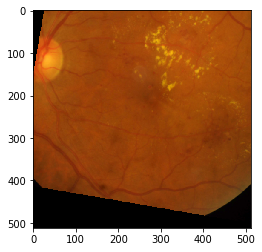

In [40]:
plt.imshow(train_dataset[120][0].permute(1, 2, 0))

In [46]:
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=5)

Loaded pretrained weights for efficientnet-b4


In [47]:
# model.load_state_dict(torch.load("./model/efficientnet_os.ptm"))

In [48]:
model = model.to(device)
model = nn.DataParallel(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [61]:
global_start_time = time.time()
train_res, test_res = train_loop(NUM_EPOCHS, train_loader, val_loader, model, criterion, optimizer)

1 [0/20]	time 4.766 (4.766)	loss 0.1682 (0.1682)	GAP 0.9375 (0.9375)
 * average GAP on train 0.9375
validation score: 0.5837512537612839
2 [0/20]	time 4.503 (4.503)	loss 0.1436 (0.1436)	GAP 1.0000 (1.0000)
 * average GAP on train 0.9313
validation score: 0.5829983922829582
3 [0/20]	time 4.438 (4.438)	loss 0.1311 (0.1311)	GAP 1.0000 (1.0000)
 * average GAP on train 0.9344
validation score: 0.5550039714058776
4 [0/20]	time 4.678 (4.678)	loss 0.1351 (0.1351)	GAP 1.0000 (1.0000)
 * average GAP on train 0.9344
validation score: 0.5700338712891014
5 [0/20]	time 4.990 (4.990)	loss 0.1279 (0.1279)	GAP 0.9375 (0.9375)
 * average GAP on train 0.9437
validation score: 0.565269943593876
6 [0/20]	time 4.545 (4.545)	loss 0.2107 (0.2107)	GAP 0.8750 (0.8750)
 * average GAP on train 0.9187
validation score: 0.5658821162743914
7 [0/20]	time 4.539 (4.539)	loss 0.1257 (0.1257)	GAP 1.0000 (1.0000)
 * average GAP on train 0.9219
validation score: 0.601998001998002
8 [0/20]	time 4.694 (4.694)	loss 0.1414 (0.

In [62]:
predicts, confs, targets = inference(val_loader, model)

In [63]:
confusion_matrix(targets.cpu(), predicts.cpu())

array([[27,  0,  0,  0,  0],
       [ 4,  0,  0,  0,  0],
       [ 6,  0, 13,  8,  0],
       [ 0,  0,  2, 12,  1],
       [ 2,  0,  0,  1,  7]])

In [64]:
cohen_kappa_score(targets.cpu(), predicts.cpu())

0.6044479745830025

In [65]:
torch.save(model.state_dict(), "../model/efficientnet_jpg.ptm")

# jpeg model

In [68]:
train_df, val_df = train_test_split(jpeg_labels, test_size=0.2,stratify=jpeg_labels['Drscore'], random_state = seed)

In [69]:
train_dataset = ImageDataset(train_df, mode='train')
val_dataset = ImageDataset(val_df, mode='val')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          drop_last=True, shuffle=True, num_workers=NUM_WORKERS)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=NUM_WORKERS)

In [70]:
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=5)

Loaded pretrained weights for efficientnet-b4


In [71]:
# model.load_state_dict(torch.load("./model/efficientnet_os.ptm"))

In [72]:
model = model.to(device)
model = nn.DataParallel(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [73]:
global_start_time = time.time()
train_res, test_res = train_loop(NUM_EPOCHS, train_loader, val_loader, model, criterion, optimizer)

1 [0/626]	time 4.208 (4.208)	loss 1.6387 (1.6387)	GAP 0.1875 (0.1875)
1 [50/626]	time 0.783 (0.845)	loss 1.0934 (1.4068)	GAP 0.8750 (0.6091)
1 [100/626]	time 0.775 (0.811)	loss 0.8102 (1.2302)	GAP 0.8125 (0.6757)
1 [150/626]	time 0.764 (0.798)	loss 1.0747 (1.1049)	GAP 0.5625 (0.7003)
1 [200/626]	time 0.770 (0.792)	loss 0.6935 (1.0459)	GAP 0.7500 (0.7077)
1 [250/626]	time 0.766 (0.789)	loss 0.7518 (0.9968)	GAP 0.8125 (0.7151)
1 [300/626]	time 0.772 (0.787)	loss 0.5714 (0.9710)	GAP 0.8125 (0.7178)
1 [350/626]	time 0.777 (0.786)	loss 0.7124 (0.9484)	GAP 0.7500 (0.7172)
1 [400/626]	time 0.768 (0.784)	loss 0.8899 (0.9318)	GAP 0.6875 (0.7179)
1 [450/626]	time 0.774 (0.783)	loss 0.8852 (0.9113)	GAP 0.7500 (0.7201)
1 [500/626]	time 0.765 (0.783)	loss 0.7237 (0.8958)	GAP 0.7500 (0.7219)
1 [550/626]	time 0.776 (0.782)	loss 0.5898 (0.8801)	GAP 0.7500 (0.7257)
1 [600/626]	time 0.767 (0.782)	loss 0.9109 (0.8698)	GAP 0.6875 (0.7270)
 * average GAP on train 0.7272
validation score: 0.3863482801762936

9 [150/626]	time 0.774 (0.804)	loss 0.6294 (0.4353)	GAP 0.8125 (0.8444)
9 [200/626]	time 0.770 (0.798)	loss 0.6121 (0.4356)	GAP 0.8125 (0.8436)
9 [250/626]	time 0.770 (0.793)	loss 0.4524 (0.4311)	GAP 0.8125 (0.8471)
9 [300/626]	time 0.769 (0.790)	loss 0.3499 (0.4307)	GAP 0.8750 (0.8478)
9 [350/626]	time 0.769 (0.789)	loss 0.7968 (0.4308)	GAP 0.6875 (0.8486)
9 [400/626]	time 0.771 (0.787)	loss 0.6206 (0.4279)	GAP 0.7500 (0.8498)
9 [450/626]	time 0.776 (0.786)	loss 0.3590 (0.4300)	GAP 0.9375 (0.8502)
9 [500/626]	time 0.772 (0.785)	loss 0.3856 (0.4320)	GAP 0.8125 (0.8497)
9 [550/626]	time 0.771 (0.785)	loss 0.2580 (0.4332)	GAP 0.8750 (0.8498)
9 [600/626]	time 0.772 (0.784)	loss 0.6375 (0.4343)	GAP 0.8125 (0.8490)
 * average GAP on train 0.8491
validation score: 0.5974256714829229
10 [0/626]	time 4.169 (4.169)	loss 0.2208 (0.2208)	GAP 1.0000 (1.0000)
10 [50/626]	time 0.779 (0.849)	loss 0.5097 (0.4749)	GAP 0.9375 (0.8346)
10 [100/626]	time 0.775 (0.814)	loss 0.6177 (0.4256)	GAP 0.7500 (0.85

17 [250/626]	time 0.768 (0.792)	loss 0.0866 (0.2156)	GAP 1.0000 (0.9258)
17 [300/626]	time 0.774 (0.789)	loss 0.3531 (0.2185)	GAP 0.8750 (0.9259)
17 [350/626]	time 0.769 (0.787)	loss 0.0308 (0.2214)	GAP 1.0000 (0.9243)
17 [400/626]	time 0.770 (0.786)	loss 0.1749 (0.2178)	GAP 0.9375 (0.9249)
17 [450/626]	time 0.769 (0.784)	loss 0.3400 (0.2243)	GAP 0.8750 (0.9225)
17 [500/626]	time 0.774 (0.784)	loss 0.0835 (0.2211)	GAP 0.9375 (0.9235)
17 [550/626]	time 0.773 (0.783)	loss 0.0781 (0.2181)	GAP 1.0000 (0.9242)
17 [600/626]	time 0.770 (0.783)	loss 0.2043 (0.2181)	GAP 0.8750 (0.9240)
 * average GAP on train 0.9232
validation score: 0.5739996884720497
18 [0/626]	time 3.987 (3.987)	loss 0.2063 (0.2063)	GAP 0.9375 (0.9375)
18 [50/626]	time 0.770 (0.845)	loss 0.1490 (0.1548)	GAP 0.9375 (0.9522)
18 [100/626]	time 0.772 (0.810)	loss 0.1707 (0.1755)	GAP 0.9375 (0.9400)
18 [150/626]	time 0.769 (0.798)	loss 0.3453 (0.1756)	GAP 0.8125 (0.9367)
18 [200/626]	time 0.772 (0.793)	loss 0.3272 (0.1850)	GAP 0.

In [74]:
torch.save(model.state_dict(), "../model/efficientnet_jpeg.ptm")

In [41]:
df = pd.DataFrame({'train':train_res, 'val':test_res})

In [43]:
df.to_csv("../logs/efficientnet_jpeg_log.csv", index=False)

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [ ]:
time.sleep(5)

In [ ]:
predicts, confs, targets = inference(val_loader, model)

In [ ]:
confusion_matrix(targets.cpu(), predicts.cpu())

In [ ]:
time.sleep(5)

In [ ]:
!sudo shutdown now